In [1]:
# IMPORTS #

# For handeling FITS files
from astropy.io import fits
import scipy
from glob import glob

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 26})
plt.rcParams["figure.figsize"] = (12,12)

# Determining Readout Noise and Gain

In [3]:
bIm = fits.open(r"/home/daraghhollman/jupyter/UCD_PASS_Labs/CCDs/Data_D1/daragh_ccd/bias/bias_01.fit")
print(bIm[0].header)

SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                  100                                                  NAXIS2  =                  100                                                  BZERO   =           32768.000000                                                BSCALE  =             1.000000                                                  DATAMIN =             0.000000                                                  DATAMAX =           65535.000000                                                INSTRUME=           'ATIK-314L: fw rev 3.01'                                    FILTER  =           'Position 1'                                                EXPTIME =           0.001                                                       DATE-OBS=           '2022-10-05T14:01:39

In [4]:
fIm = fits.open(r"/home/daraghhollman/jupyter/UCD_PASS_Labs/CCDs/Data_D1/daragh_ccd/flat/flat_03.fit")
print(fIm[0].header)

SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                  100                                                  NAXIS2  =                  100                                                  BZERO   =           32768.000000                                                BSCALE  =             1.000000                                                  DATAMIN =             0.000000                                                  DATAMAX =           65535.000000                                                INSTRUME=           'ATIK-314L: fw rev 3.01'                                    FILTER  =           'Position 1'                                                EXPTIME =           0.100                                                       DATE-OBS=           '2022-10-05T14:29:49

In [10]:
biasFilesA = glob(r"/home/daraghhollman/jupyter/UCD_PASS_Labs/CCDs/Data_D1/daragh_ccd/bias/bias*")
biasFilesB = glob(r"/home/daraghhollman/jupyter/UCD_PASS_Labs/CCDs/Data_D1/daragh_ccd/bias_1/bias*")

biasFITSA = [fits.open(el) for el in biasFilesA] # A list of 30 fits files
biasFITSB = [fits.open(el) for el in biasFilesB] # A list of 30 fits files
biasFITS = biasFITSA+biasFITSB

In [11]:
flatFiles = glob(r"/home/daraghhollman/jupyter/UCD_PASS_Labs/CCDs/Data_D1/daragh_ccd/flat/flat*")

flatFITS = [fits.open(el) for el in flatFiles] # A list of 15 fits files

In [12]:
# Inputs a list of images, loops through every pixel of each image. Returns a list of the average value of each image
def findAverageCounts(fitsList):
    averages = [0] * len(fitsList)
    
    n = 0
    for image in fitsList:
        total = 0
        count = 1
        for line in image[0].data:
            for el in line:
                total+=el
                count+=1
        averages[n] = total / count
        n+=1
    return averages

In [13]:
# Biases
i=0
myFlats = list()
while i < len(flatFITS):
    # Check if there are still pairs left
    if (len(flatFITS) - i) >= 2:
        myFlats.append([flatFITS[i], flatFITS[i+1]])
        i+=2

j = 0
myBiases = list()
while j < len(biasFITS):
    # Check there still exist pairs
    if (len(biasFITS) - i >= 2):
        myBiases.append([biasFITS[j], biasFITS[j+1]])
        j+=2

def gainAndReadnoise(flats, biases, std=False): 
    # where flats and biases are lists with elements containing pairs of flats or biases
    
    gainList = list()
    readnoiseList = list()
    
    for flatPair, biasPair in zip(flats, biases):
        meanFlats = [flatPair[0][0].data.mean(), flatPair[1][0].data.mean()]
        meanBiases = [biasPair[0][0].data.mean(), biasPair[1][0].data.mean()]
        
        flatDiff = (flatPair[0][0].data - flatPair[1][0].data)
        biasDiff = (biasPair[0][0].data - biasPair[1][0].data)
        
        std_flatDiff = flatDiff.std()
        std_biasDiff = biasDiff.std()
        
        gain = ((meanFlats[0] + meanFlats[1]) - (meanBiases[0] + meanBiases[1])) / (std_flatDiff**2 - std_biasDiff**2)
        readnoise = gain * std_biasDiff / np.sqrt(2)
        
        gainList.append(gain)
        readnoiseList.append(readnoise)
    
    averageGain = np.mean(gainList)
    std_gain = np.std(gainList)
    averageReadnoise = np.mean(readnoiseList)
    std_readnoise = np.std(readnoiseList)
    
    if std==True: return [[averageGain, averageReadnoise], [std_gain, std_readnoise]]
    else: return [averageGain, averageReadnoise]

res = gainAndReadnoise(myFlats, myBiases, std=True)
gain = res[0][0]
readnoise = res[0][1]

print(f"Gain: {gain} with standarad deviation: {res[1][0]}")
print(f"Readnoise: {readnoise} with standarad deviation: {res[1][1]}")

Gain: -0.001577846989986806 with standarad deviation: 0.000748331061405
Readnoise: -36.53031784248212 with standarad deviation: 17.324857482162162


# Spectrum of the Arc Lamp

Text(0, 0.5, 'y coordinate')

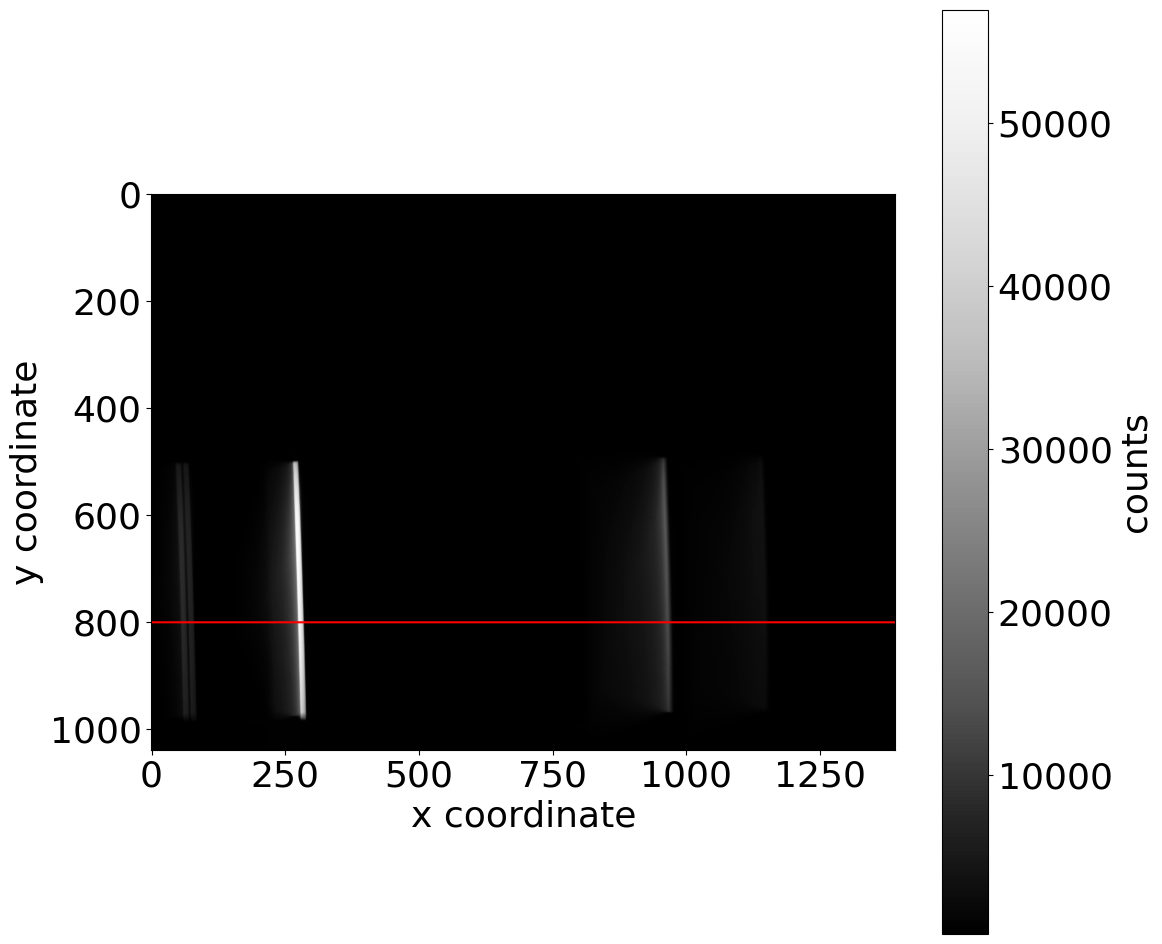

In [9]:
arcImage = fits.open(r"/home/daraghhollman/jupyter/UCD_PASS_Labs/CCDs/Data_D1/daragh_ccd/Hg/Hg_02.fit")
plt.imshow(arcImage[0].data, cmap="Greys_r")
plt.plot(np.arange(0, 1391, 1), [800]*(1391), color="red")
plt.colorbar(label="counts")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")

In [10]:
line_values = arcImage[0].data[800]
print(max(line_values))

52351


In [11]:
x= list()
y= list()

i = 0
for el in line_values:
    x.append(i)
    y.append(el)
    
    i+=1

In [12]:
def gaussian(x, mu, std, scale):
    ans = list()
    for el in x:
        ans.append(scale * np.exp(-(el-mu)**2/(2*std**2)))
    return ans

pars01, cov01 = scipy.optimize.curve_fit(gaussian, x[0:150], y[0:150], [80, 10, 10000])
pars02, cov02 = scipy.optimize.curve_fit(gaussian, x[260:290], y[260:290], [278, 4, 52000])
pars03, cov03 = scipy.optimize.curve_fit(gaussian, x[920:980], y[920:980], [950, 4, 12000])
pars04, cov04 = scipy.optimize.curve_fit(gaussian, x[1050:1200], y[1050:1200], [1125, 10, 400])

meanX = [pars01[0], pars02[0], pars03[0], pars04[0]]

Text(0, 0.5, 'Counts')

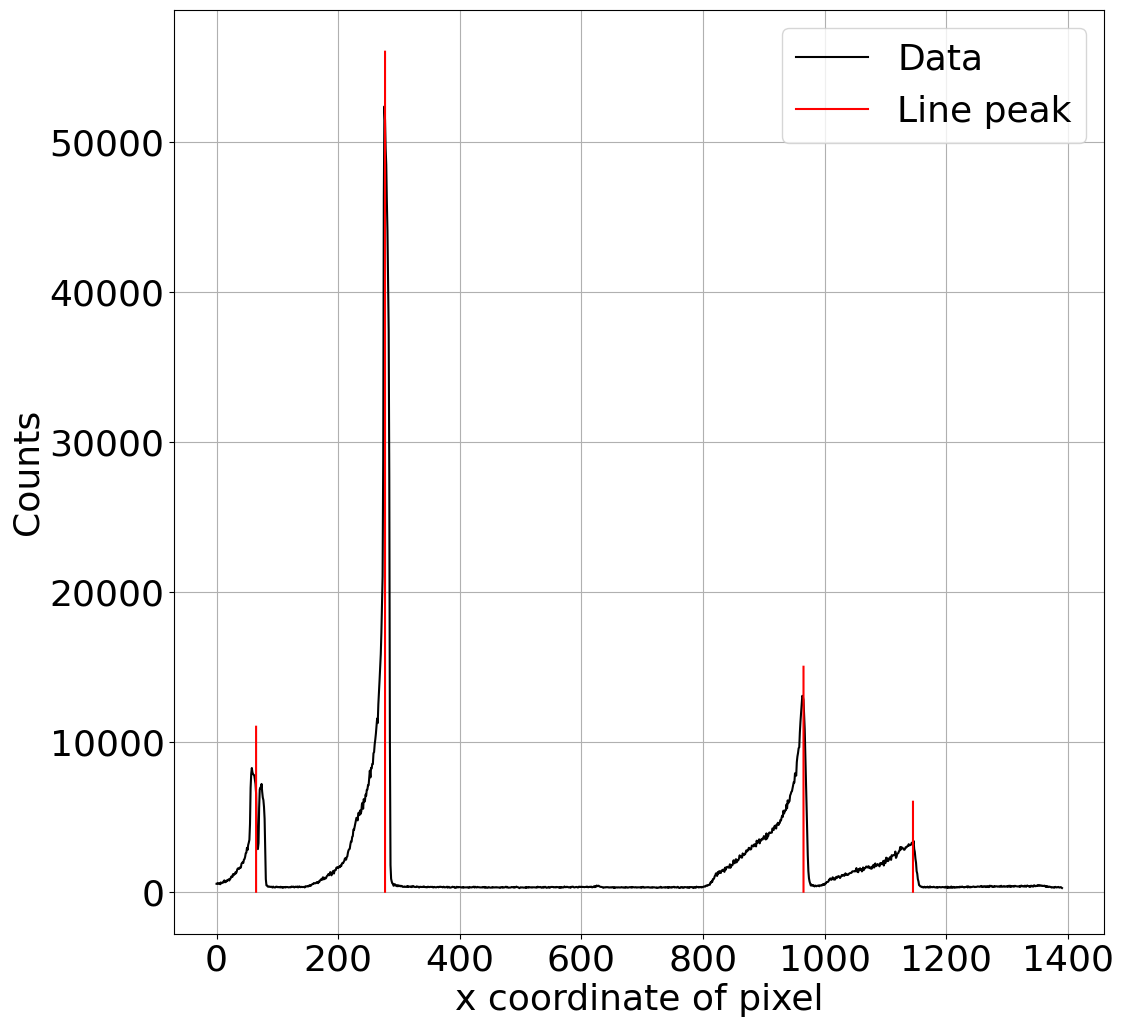

In [13]:
# First peak : [0:150]
# Second peak : [200:350]
# Third peak : [800:1100]
# Fourth peak : [1050:1200]

plt.plot(x, y, color="black", label="Data")
# Plan is to plot vertical lines displaying the estimated x and the uncertainty

# Peak 1
plt.plot([65]*11000, np.arange(0, 11000, 1), color="red")

# Peak 2
plt.plot([277]*56000, np.arange(0, 56000, 1), color="red", label="Line peak")

# Peak 3
plt.plot([965]*15000, np.arange(0, 15000, 1), color="red")

# Peak 4
plt.plot([1145]*6000, np.arange(0, 6000, 1), color="red")

plt.legend()
plt.grid()
plt.xlabel("x coordinate of pixel")
plt.ylabel("Counts")

Text(0.5, 0, 'wavelength (nm)')

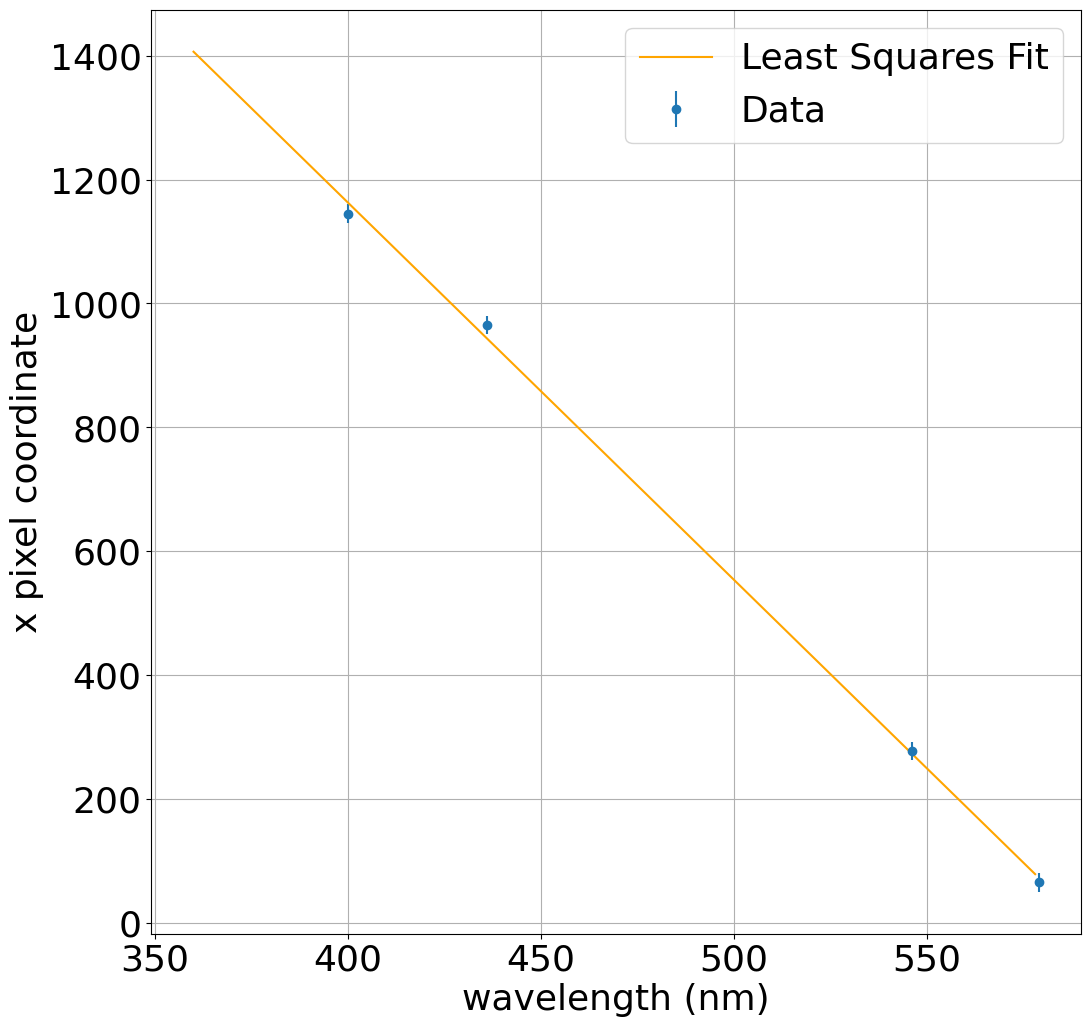

In [14]:
peakXs = [65, 277, 965, 1145]
wavelengths = [579, 546, 436, 400] # reference : https://zeiss-campus.magnet.fsu.edu/articles/lightsources/mercuryarc.html

def wavelengthToX(lam, m, c):
    return m*lam + c
def xToWavelength(x, m, c):
    return (x - c) / m

linPars, linCov = scipy.optimize.curve_fit(wavelengthToX, wavelengths, peakXs)

plt.errorbar(wavelengths, peakXs, yerr=15, label="Data", fmt="o")
plt.plot(np.arange(360, 579, 1), \
         wavelengthToX(np.arange(360, 579, 1), linPars[0], linPars[1]), color="orange", label="Least Squares Fit")

plt.legend()
plt.grid()
plt.ylabel("x pixel coordinate")
plt.xlabel("wavelength (nm)")

# Investigate the Resolution of the Spectrograph

In [15]:
imageNa = fits.open(r"/home/daraghhollman/jupyter/UCD_PASS_Labs/CCDs/Data_D1/daragh_ccd/Na_Main/Na_Main/Na_204.fit")
print(np.shape(imageNa[0].data))

(1039, 1391)


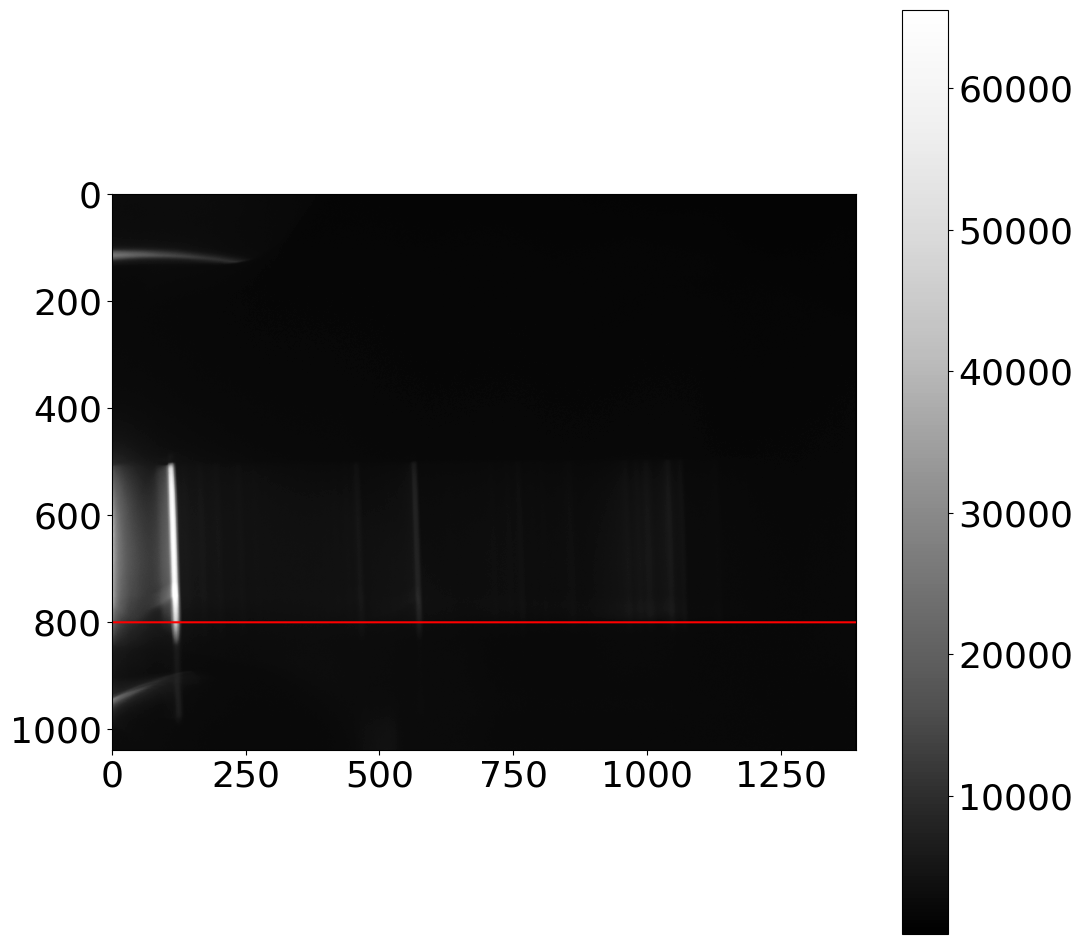

In [16]:
plt.imshow(imageNa[0].data, cmap="Greys_r")
plt.plot(np.arange(0, 1391, 1), [800]*(1391), color="red")
plt.colorbar()

In [17]:
line_valuesNa = imageNa[0].data[800]
print(max(line_valuesNa))

45180


In [18]:
xNa = list()
yNa = list()

k = 0
for el in line_valuesNa:
    xNa.append(k)
    yNa.append(el)
    
    k+=1

Text(0, 0.5, 'Counts')

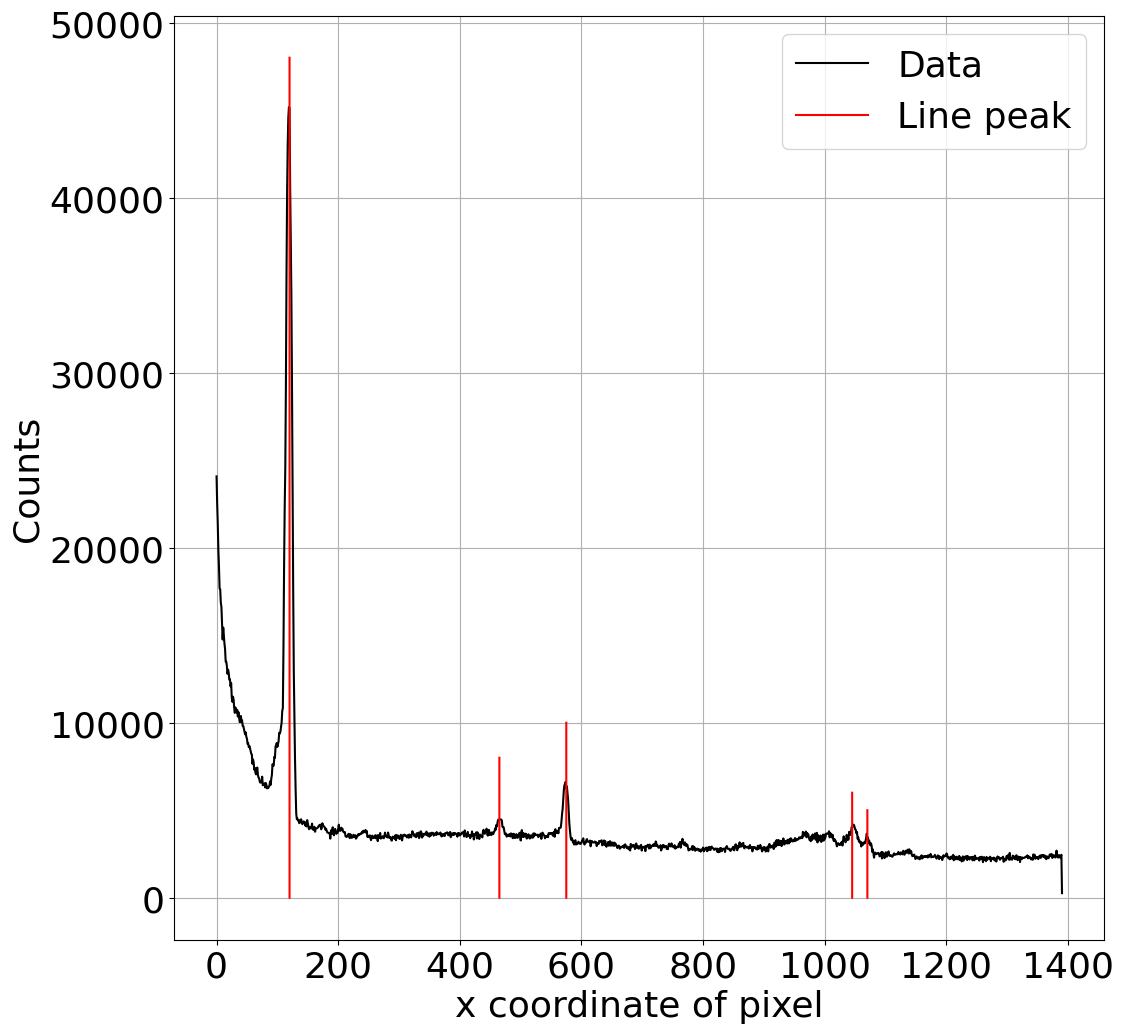

In [19]:
plt.plot(xNa, yNa, color="black", label="Data")

# Peak 1
plt.plot([120]*48000, np.arange(0, 48000, 1), color="red")
# Peak 2
plt.plot([465]*8000, np.arange(0, 8000, 1), color="red", label="Line peak")
# Peak 3
plt.plot([575]*10000, np.arange(0, 10000, 1), color="red")
# Peak 4
plt.plot([1045]*6000, np.arange(0, 6000, 1), color="red")
# Peak 5
plt.plot([1070]*5000, np.arange(0, 5000, 1), color="red")

plt.legend()
plt.grid()
plt.xlabel("x coordinate of pixel")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

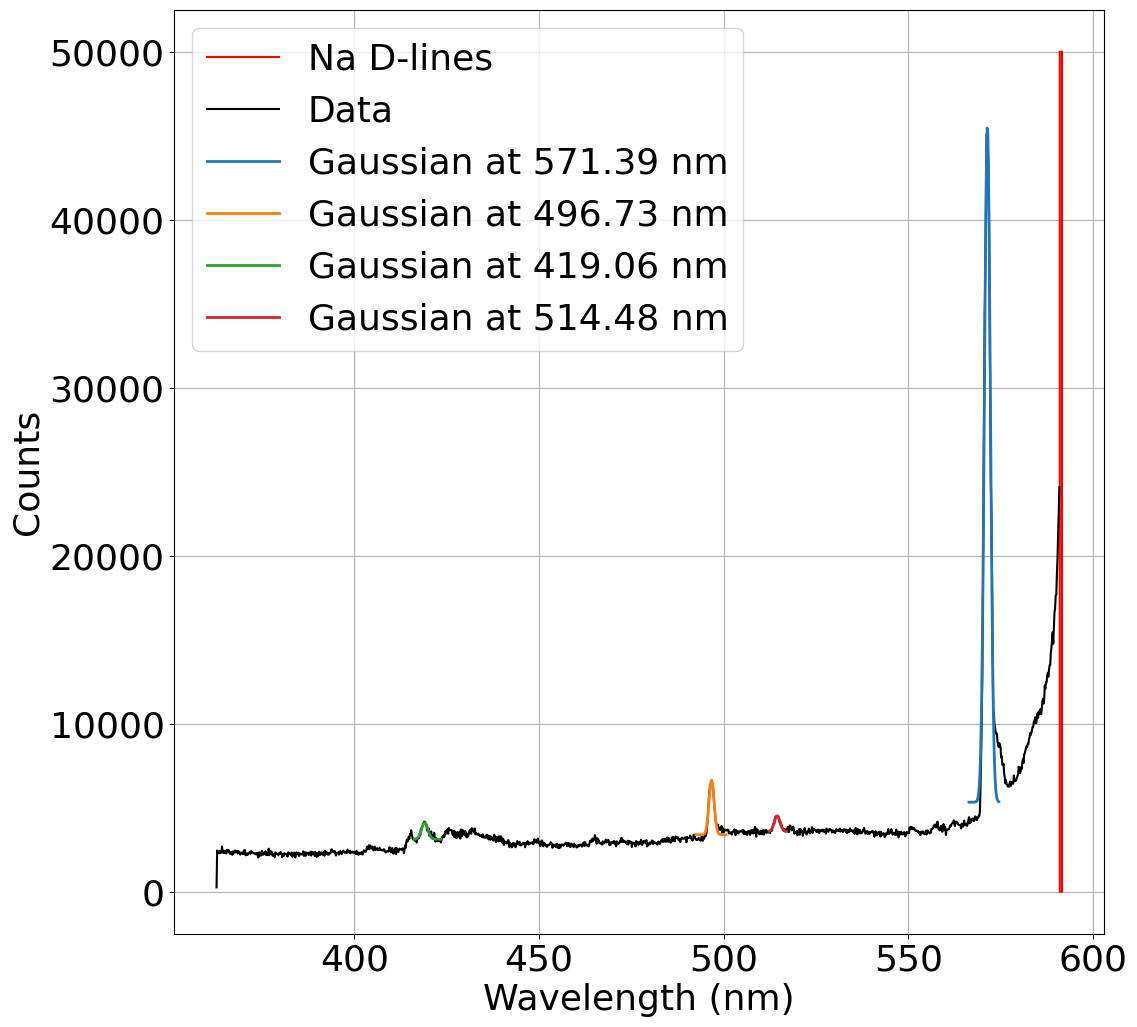

In [20]:
peaksNa = [120, 465, 575, 1045, 1070]

# https://www.chem.uci.edu/~unicorn/249/Handouts/RWFSodium.pdf
NaDWavelengths = [588.995, 589.5924]
plt.plot([NaDWavelengths[0]+2]*50000, np.arange(0, 50000, 1), color="red", label="Na D-lines")
plt.plot([NaDWavelengths[1]+2]*50000, np.arange(0, 50000, 1), color="red")

# Plot of Na data
NaWavelengths = [xToWavelength(el, linPars[0], linPars[1]) for el in xNa]

plt.plot(NaWavelengths, yNa, color="black", label="Data")

# Gaussian Fit
def gaussian(x, mean, std, C, H):
    A = C / (abs(std) * np.sqrt(2 * np.pi))
    B = np.exp(-0.5 * ((x - mean) / abs(std))**2)
    
    return A*B + H

gaussPars01, gaussCov01 = scipy.optimize.curve_fit(gaussian, NaWavelengths[100:150], yNa[100:150], \
                                               [565, 10, 40000, 5000])
gaussPars02, gaussCov02 = scipy.optimize.curve_fit(gaussian, NaWavelengths[550:600], yNa[550:600], \
                                               [495, 5, 8000, 5000])
gaussPars03, gaussCov03 = scipy.optimize.curve_fit(gaussian, NaWavelengths[1020:1065], yNa[1020:1065], \
                                               [410, 5, 4000, 3000])
gaussPars04, gaussCov04 = scipy.optimize.curve_fit(gaussian, NaWavelengths[450:480], yNa[450:480], \
                                               [520, 5, 6000, 5000])


plt.plot(NaWavelengths[100:150], gaussian(NaWavelengths[100:150], gaussPars01[0], gaussPars01[1], gaussPars01[2],  \
                                          gaussPars01[3]), label=f"Gaussian at {gaussPars01[0]:.2f} nm", linewidth="2")
plt.plot(NaWavelengths[550:600], gaussian(NaWavelengths[550:600], gaussPars02[0], gaussPars02[1], gaussPars02[2],  \
                                          gaussPars02[3]), label=f"Gaussian at {gaussPars02[0]:.2f} nm", linewidth="2")
plt.plot(NaWavelengths[1020:1065], gaussian(NaWavelengths[1020:1065], gaussPars03[0], gaussPars03[1], gaussPars03[2],  \
                                          gaussPars03[3]), label=f"Gaussian at {gaussPars03[0]:.2f} nm", linewidth="2")
plt.plot(NaWavelengths[450:480], gaussian(NaWavelengths[450:480], gaussPars04[0], gaussPars04[1], gaussPars04[2],  \
                                          gaussPars04[3]), label=f"Gaussian at {gaussPars04[0]:.2f} nm", linewidth="2")


plt.legend()
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")

## Find Resolution

In [21]:
def resolution(std, wavelength):
    dL = 2.355 * std
    res = wavelength / dL
    return res


In [22]:
def resUncertainty(wavelength, FWHM, uW, uFWHM):
    return np.sqrt((1/FWHM)**2 * uW**2 + (wavelength/(FWHM**2))**2 * uFWHM**2)

In [23]:
point1 = resolution(gaussPars01[1], gaussPars01[0])
point2 = resolution(abs(gaussPars04[1]), gaussPars04[0])
point3 = resolution(gaussPars02[1], gaussPars02[0])
point4 = resolution(gaussPars03[1], gaussPars03[0])
resolutions = [point1, point2, point3, point4]

print(f"Resolution of the spectrograph at {gaussPars01[0]:.2f} nm: {point1:.5f}")
print(f"Resolution of the spectrograph at {gaussPars04[0]:.2f} nm: {point2:.5f}")
print(f"Resolution of the spectrograph at {gaussPars02[0]:.2f} nm: {point3:.5f}")
print(f"Resolution of the spectrograph at {gaussPars03[0]:.2f} nm: {point4:.5f}")

Resolution of the spectrograph at 571.39 nm: 301.36518
Resolution of the spectrograph at 514.48 nm: 284.79700
Resolution of the spectrograph at 496.73 nm: 304.49310
Resolution of the spectrograph at 419.06 nm: 206.63528


In [39]:
uR1 = resUncertainty(gaussPars01[0], gaussPars01[1],np.sqrt(gaussCov01[0][0]), np.sqrt(gaussCov01[1][1]))
uR2 = resUncertainty(gaussPars02[0], gaussPars02[1],np.sqrt(gaussCov02[0][0]), np.sqrt(gaussCov02[1][1]))
uR3 = resUncertainty(gaussPars03[0], gaussPars03[1],np.sqrt(gaussCov03[0][0]), np.sqrt(gaussCov03[1][1]))
uR4 = resUncertainty(gaussPars04[0], gaussPars04[1],np.sqrt(gaussCov04[0][0]), np.sqrt(gaussCov04[1][1]))
uR = [uR1, uR2, uR3, uR4]
print(uR)

[17.86805221558772, 34.89525500297671, 38.51343788860465, 44.725515255856266]


0.628751594086656 -40.313700669343525
0.2629224814699645 132.34737527398428


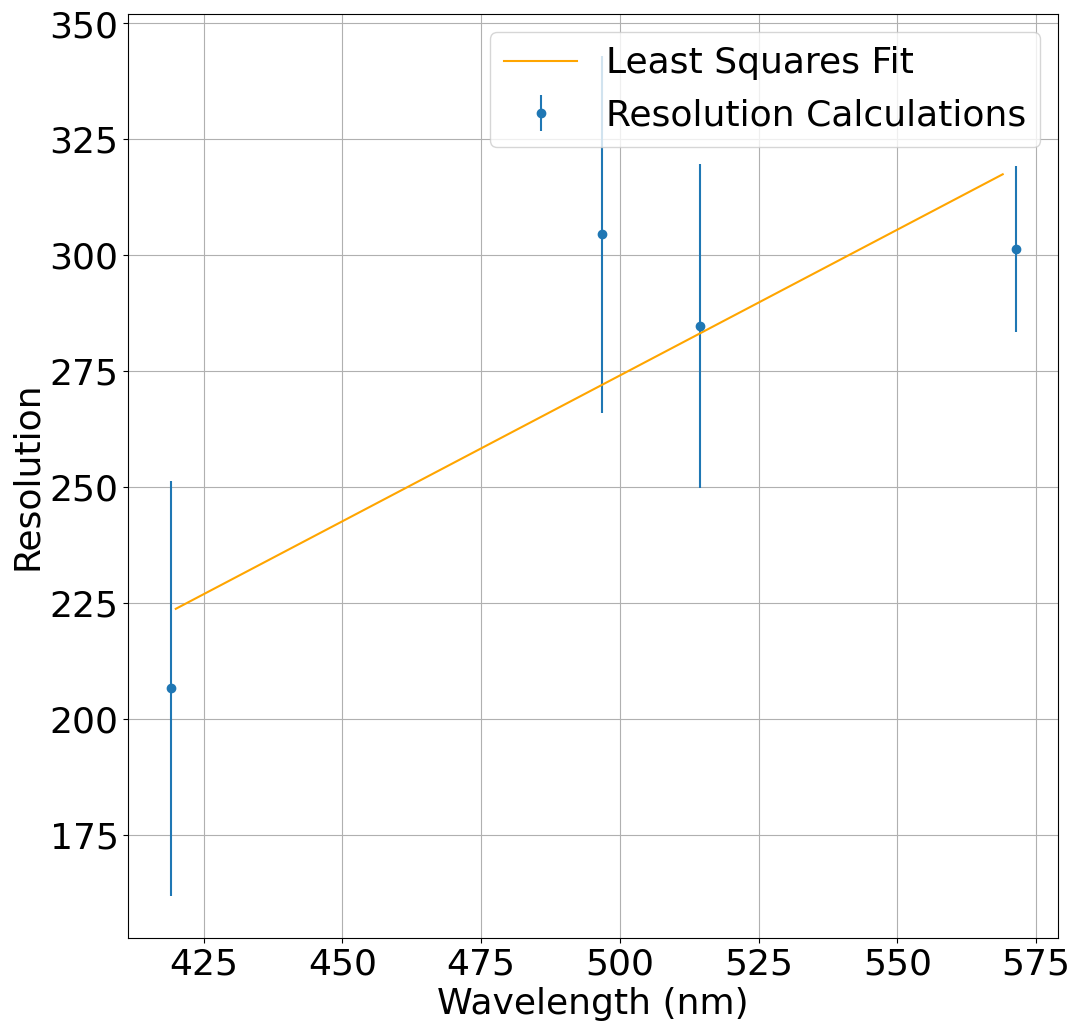

In [40]:
peaksForRes = [gaussPars01[0], gaussPars04[0], gaussPars02[0], gaussPars03[0]]
plt.errorbar(peaksForRes, resolutions, yerr=uR, label="Resolution Calculations", fmt="o")

def linFit(x, m, c):
    return x*m + c

resPars, resCov = scipy.optimize.curve_fit(linFit, peaksForRes,resolutions)
plt.plot(np.arange(420, 570, 1), linFit(np.arange(420, 570, 1), resPars[0], resPars[1]),\
         color="orange", label="Least Squares Fit")

plt.legend()
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Resolution")

print(resPars[0], resPars[1])
print(np.sqrt(resCov[0][0]), np.sqrt(resCov[1][1]))

# Effect of slit width on the resolution

In [26]:
imageSlit = fits.open(r"/home/daraghhollman/jupyter/UCD_PASS_Labs/CCDs/Data_D1/daragh_ccd/Na_Slit_big/Na_Slit_big/big/Na_773.fit")
print(np.shape(imageSlit[0].data))

(1039, 1391)


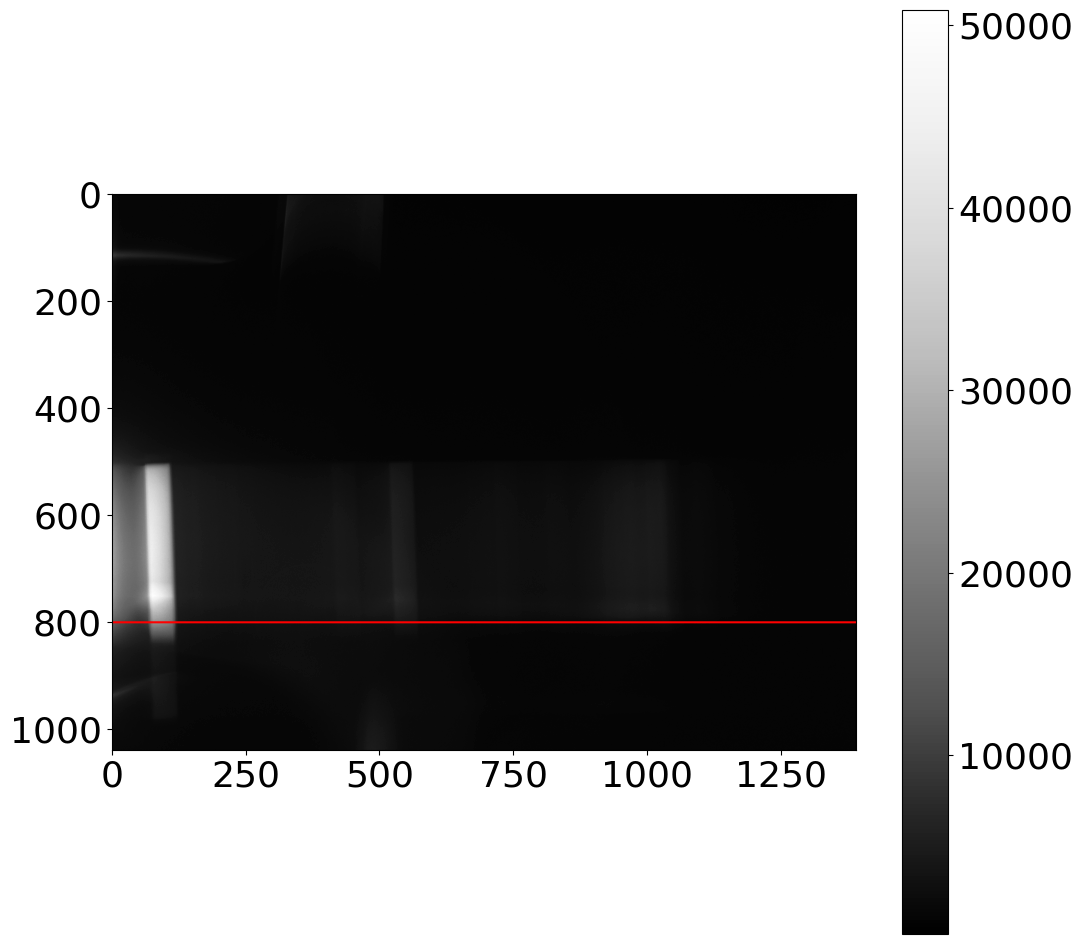

In [27]:
plt.imshow(imageSlit[0].data, cmap="Greys_r")
plt.plot(np.arange(0, 1391, 1), [800]*(1391), color="red")
plt.colorbar()

In [28]:
line_valuesSlit = imageSlit[0].data[800]
print(max(line_valuesSlit))

24947


In [29]:
xSlit = list()
ySlit = list()

k = 0
for el in line_valuesSlit:
    xSlit.append(k)
    ySlit.append(el)
    
    k+=1

Text(0, 0.5, 'Counts')

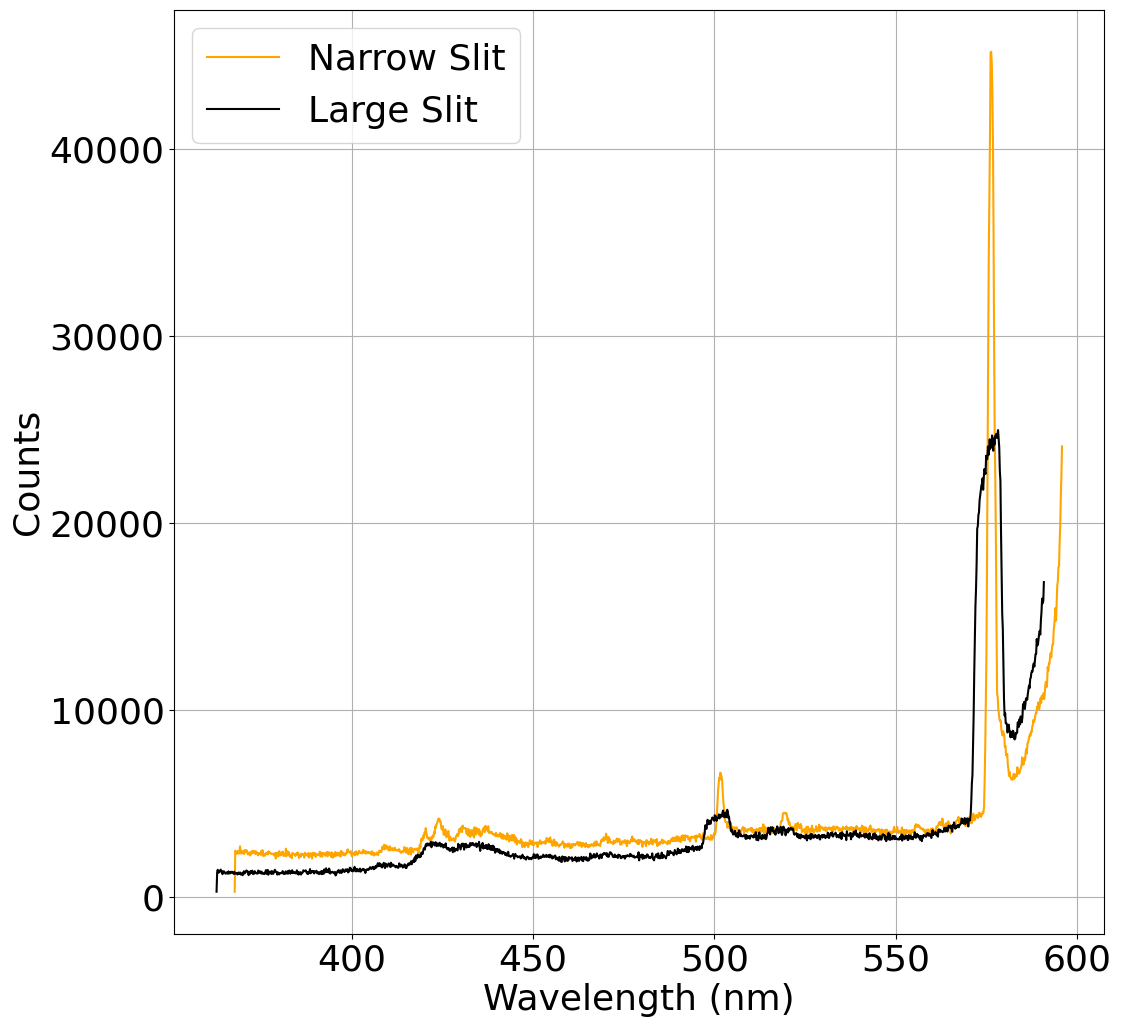

In [30]:
offset = 5
plt.plot([el + offset for el in NaWavelengths], yNa, color="orange", label="Narrow Slit")
plt.plot(xToWavelength(xSlit, linPars[0], linPars[1]), ySlit, color="black", label="Large Slit")

plt.legend()
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")

Note that the peaks are all wider which will yield a larger standard deviation and hence a smaller resolution, accuracy decreases. The images were taken at different exposures to avoid peaking the data however it is clear that the larger slit has wider peaks.